# Excitation Backprop Tutorial: ImageNet Classification

Sam Greydanus. March 2018. MIT License.

In this notebook, we'll use excitation backprop (EB) to explore a VGG-16 model trained on ImageNet.

For an in-depth explanation of EB, refer to [this paper](https://arxiv.org/abs/1608.00507). The [original code](https://github.com/jimmie33/Caffe-ExcitationBP) is in Caffe.

In [26]:
%reload_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function, Variable
from torchvision import datasets, models, transforms, utils

import numpy as np
import matplotlib.pyplot as plt

import os, sys, copy ; sys.path.append('..')
import techniques.excitationbp as eb

reseed = lambda: np.random.seed(seed=1) ; ms = torch.manual_seed(1) # for reproducibility
reseed()
from techniques.rise_utils import *

In [27]:
from techniques.eb_api import gen_eb

### 1) Load a pretrained model

We'll use the built-in Torch utility.

In [32]:
# torch has a clean api for loading this model
model = models.vgg16(pretrained=True)
_ = model.train(False) # put model in evaluation mode

# get imagenet class labels from local file
class_labels = []
with open('techniques/excitationbp/data/imagenet/labels.txt', 'r') as f:
    for line in f:
        class_labels.append(line[:-1])

In [33]:
paths = []
for r, d, f in os.walk('data/ILSVRC2012_img_val/'):
    for file in f:
        if '.JPEG' in file:
            paths.append(os.path.join(r, file))
#random.shuffle(paths)
data_iter = iter(paths)
print("Number of test images: {0}".format(len(paths)))

path = next(data_iter)

Number of test images: 47779


using excitation backprop autograd mode:
	->replacing torch.nn.functional.linear with eb_linear...
	->replacing torch.nn.functional.conv{1,2,3}d with eb_conv{1,2,3}d...
	->replacing torch.nn.functional.avg_pool2d with eb_avg_pool2d...


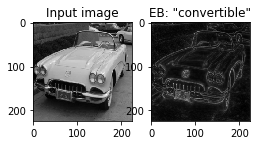

In [34]:
eb_sal = gen_eb(path, 'vgg19')

In [31]:
img = read_tensor(path)
X = Variable(img.resize_(1,3,224,224), requires_grad=True)
y_hat = model(X)
class_id = y_hat.max(1)[1].data.numpy()[0]

In [10]:
eb.use_eb(True)
inputs = read_tensor(path)
inputs = Variable(inputs.resize_(1,3,224,224))

# compute excitation backprop for correct label
cat_id = 551
#dog_id = 219
prob_outputs_cat = Variable(torch.zeros(1,1000)) ; prob_outputs_cat.data[:,cat_id] += 1
#prob_outputs_dog = Variable(torch.zeros(1,1000)) ; prob_outputs_dog.data[:,dog_id] += 1

prob_inputs_cat = eb.excitation_backprop(model, inputs, prob_outputs_cat, contrastive=False)
#prob_inputs_dog = eb.excitation_backprop(model, inputs, prob_outputs_dog, contrastive=False)

using excitation backprop autograd mode:
	->replacing torch.nn.functional.linear with eb_linear...
	->replacing torch.nn.functional.conv{1,2,3}d with eb_conv{1,2,3}d...
	->replacing torch.nn.functional.avg_pool2d with eb_avg_pool2d...


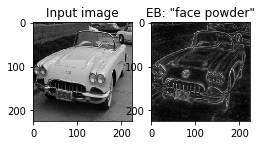

In [11]:
beta = 0.5 # adjust the 'peakiness' of data
cat_img = prob_inputs_cat.clamp(min=0).sum(0).sum(0).data.numpy()
#dog_img = prob_inputs_dog.clamp(min=0).sum(0).sum(0).data.numpy()

# visualize
s = 2
f = plt.figure(figsize=[s*3,s])
plt.subplot(1,3,1)
plt.title('Input image')
plt.imshow(inputs.data.sum(0).sum(0).numpy(), cmap='gray')

plt.subplot(1,3,2)
plt.title('EB: "{}"'.format(class_labels[cat_id][:15]))
plt.imshow(cat_img**beta, cmap='gray')

#plt.subplot(1,3,3)
#plt.title('EB: "{}"'.format(class_labels[dog_id][:15]))
#plt.imshow(dog_img**beta, cmap='gray')
plt.show() #; f.savefig('figures/imagenet-eb.png', bbox_inches='tight')

### 2) Load/classify an example image

In [3]:
# init a few bookkeeping variables
fig_dir = 'techniques/excitationbp/figures/'
data_dir = 'techniques/excitationbp/data/imagenet'

# make the dataloader
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(data_dir, transforms.Compose([
        transforms.ToTensor(), normalize,])), batch_size=1)

# load image and classify
data = train_loader.dataset[0][0] # there's just one example image in the data directory. You can add more.

X = Variable(data.resize_(1,3,224,224), requires_grad=True)
y_hat = model(X)
class_id = y_hat.max(1)[1].data.numpy()[0]

# display results
plt.figure(figsize=(4,4))
im = np.mean(data.numpy().reshape(3,224,224), axis=0)
plt.title('prediction: {}'.format(class_labels[class_id][:16]), fontsize=12)
plt.imshow(im, cmap='gray') ; plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'data/imagenet'

### 3) Enter EB Mode
Refer to **Alg. 1** in the original paper. The relevant (general) equation is:

$$ P_n = A_n \odot W^+ \left(\frac{P_{n-1}}{W^{+T}A_n}\right) $$
    
We need to do this to the Linear and Conv functions for the model we just trained. Other functions that need this extension include:
 * average pooling
 * any pointwise function that has a min value less than 0
     * these must have their min values subtracted from their outputs

In [ ]:
eb.use_eb(True)

### 4) Excitation Backprop (EB)

In [ ]:
inputs = train_loader.dataset[0][0]
inputs = Variable(inputs.resize_(1,3,224,224))

# compute excitation backprop for correct label
cat_id = 281
dog_id = 219
prob_outputs_cat = Variable(torch.zeros(1,1000)) ; prob_outputs_cat.data[:,cat_id] += 1
prob_outputs_dog = Variable(torch.zeros(1,1000)) ; prob_outputs_dog.data[:,dog_id] += 1

prob_inputs_cat = eb.excitation_backprop(model, inputs, prob_outputs_cat, contrastive=False)
prob_inputs_dog = eb.excitation_backprop(model, inputs, prob_outputs_dog, contrastive=False)

In [ ]:
beta = 0.5 # adjust the 'peakiness' of data
cat_img = prob_inputs_cat.clamp(min=0).sum(0).sum(0).data.numpy()
dog_img = prob_inputs_dog.clamp(min=0).sum(0).sum(0).data.numpy()

# visualize
s = 3
f = plt.figure(figsize=[s*3,s])
plt.subplot(1,3,1)
plt.title('Input image')
plt.imshow(inputs.data.sum(0).sum(0).numpy(), cmap='gray')

plt.subplot(1,3,2)
plt.title('EB: "{}"'.format(class_labels[cat_id][:15]))
plt.imshow(cat_img**beta, cmap='gray')

plt.subplot(1,3,3)
plt.title('EB: "{}"'.format(class_labels[dog_id][:15]))
plt.imshow(dog_img**beta, cmap='gray')
plt.show() #; f.savefig('figures/imagenet-eb.png', bbox_inches='tight')

### 5) Contrastive Excitation Backprop (c-EB)

In [7]:
prob_inputs_cat = eb.excitation_backprop(model, inputs, prob_outputs_cat, contrastive=True)
prob_inputs_dog = eb.excitation_backprop(model, inputs, prob_outputs_dog, contrastive=True)

cat_img = prob_inputs_cat.clamp(min=0).sum(0).sum(0).data.numpy()
dog_img = prob_inputs_dog.clamp(min=0).sum(0).sum(0).data.numpy()

# visualize
s = 3
f = plt.figure(figsize=[s*3,s])
plt.subplot(1,3,1)
plt.title('Input image')
plt.imshow(inputs.data.sum(0).sum(0).numpy(), cmap='gray')

plt.subplot(1,3,2)
plt.title('c-EB: "{}"'.format(class_labels[cat_id][:15]))
plt.imshow(cat_img**beta, cmap='gray')

plt.subplot(1,3,3)
plt.title('c-EB: "{}"'.format(class_labels[dog_id][:15]))
plt.imshow(dog_img**beta, cmap='gray')
plt.show() ; f.savefig('figures/imagenet-ceb.png', bbox_inches='tight')

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

### 6) c-EB to a pooling layer

In [8]:
target_layer = 6
print('Our target layer is: {}'.format( eb.utils.trainable_modules(model)[target_layer] ))

prob_inputs_cat = eb.excitation_backprop(model, inputs, prob_outputs_cat, contrastive=True, target_layer=target_layer)
prob_inputs_dog = eb.excitation_backprop(model, inputs, prob_outputs_dog, contrastive=True, target_layer=target_layer)

cat_img = prob_inputs_cat.clamp(min=0).mean(0).mean(0).data.numpy() # mean over all channels
dog_img = prob_inputs_dog.clamp(min=0).mean(0).mean(0).data.numpy() # mean over all channels

# visualize
s = 3
f = plt.figure(figsize=[s*3,s])
plt.subplot(1,3,1)
plt.title('Input image')
plt.imshow(inputs.data.sum(0).sum(0).numpy(), cmap='gray')

plt.subplot(1,3,2)
plt.title('c-EB (layer {}): "{}"'.format(target_layer, class_labels[cat_id][:10]))
plt.imshow(cat_img**beta, cmap='gray')

plt.subplot(1,3,3)
plt.title('c-EB (layer {}): "{}"'.format(target_layer, class_labels[dog_id][:10]))
plt.imshow(dog_img**beta, cmap='gray')
plt.show() ; f.savefig('figures/imagenet-pool-ceb.png', bbox_inches='tight')

Our target layer is: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.